In [1]:
%matplotlib widget
import numpy as np
import scipy.io
import cv2
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as ROT
from mpl_toolkits.mplot3d import Axes3D 
import plotly.graph_objs as go
import natsort


# Load the .mat file
data = scipy.io.loadmat('stereoParams_handeye2.mat')

# Access variables 
K1 = np.array(data['cameraMatrix1'])
D1 = np.array(data['distCoeffs1']).squeeze()
K2 = np.array(data['cameraMatrix2'])
D2 = np.array(data['distCoeffs2']).squeeze()
R = np.array(data['R'])
T = np.array(data['T']).squeeze()

# Define functions
def to_homogeneous(R, t):
    T = np.eye(4)
    T[:3,:3] = R
    T[:3,3] = t.ravel()
    return T

In [2]:
basePath = '/Users/kaitohara-lee/Library/CloudStorage/OneDrive-Queen\'sUniversity/School/UTokyo/Project'
method = 'BL'
resolution = '1280x720'
handeyefolder = 'handeye2'
testfolder = 'handeyetest3'

# Build folder paths (like fullfile in MATLAB)
leftFolder = os.path.join(basePath, handeyefolder, method, resolution, 'left')
rightFolder = os.path.join(basePath, handeyefolder, method, resolution, 'right')

# Get sorted list of PNG files
leftImages = natsort.natsorted(glob.glob(os.path.join(leftFolder, '*.png')))
rightImages = natsort.natsorted(glob.glob(os.path.join(rightFolder, '*.png')))

# Read image size from the first image
if leftImages:
    firstImage = cv2.imread(leftImages[0])
    image_size = (firstImage.shape[1],firstImage.shape[0],)  # (height,width)
else:
    raise ValueError("No images found in the left folder.")

# Print image size
print("Image size:", image_size)

Image size: (1280, 720)


In [3]:
# Perform stereo rectification to get rectified camera matrices and projection matrices
# R1, R2 are the rectification rotations, P1, P2 are the projection matrices, Q is the disparity-to-depth mapping matrix
R1, R2, P1, P2, Q, roi1, roi2 = cv2.stereoRectify(
    K1, D1, K2, D2, image_size, R, T, newImageSize=image_size, alpha=0)

# Initialize undistort rectify maps
# These maps can be used to remap the images to rectify them
map1_x, map1_y = cv2.initUndistortRectifyMap(K1, D1, R1, P1[0:3, 0:3], image_size, cv2.CV_32FC1)
map2_x, map2_y = cv2.initUndistortRectifyMap(K2, D2, R2, P2[0:3, 0:3], image_size, cv2.CV_32FC1)

numPoses = len(leftImages)

badImages = []  # List to store indices of bad images
object_points = []  # to store 3D points for all chessboard images (world coordinate frame)
image_points = []   # to store 2D points for all chessboard images (camera coordinate frame)

#Print the number of images
# print(f"Number of images: {numPoses}")

# Inputs
num_squares_x = 10                               # Number of chessboard squares along the x-axis
num_squares_y = 7                              # Number of chessboard squares along the y-axis
num_interior_corners_x = num_squares_x - 1      # Number of interior corners along x-axis
num_interior_corners_y = num_squares_y - 1      # Number of interior corners along y-axis
checker_width = 10.006                       # Checker width (in mm)

# Generate corresponding world points for this pose checkerboard
object_points_3D = np.zeros((num_interior_corners_x * num_interior_corners_y, 3), np.float32)
object_points_3D[:, :2] = np.mgrid[0:num_interior_corners_x, 0:num_interior_corners_y].T.reshape(-1, 2)
object_points_3D = object_points_3D * checker_width

In [4]:
# #plot object points
# fig = plt.figure(figsize=(8, 6))
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(object_points_3D[:, 0], object_points_3D[:, 1], object_points_3D[:, 2], c='b', marker='o', label='Object Points')
# ax.scatter(object_points_3D[0, 0], object_points_3D[0, 1], object_points_3D[0, 2], c='r', marker='o', label='First Object Point', s=100)
# ax.scatter(object_points_3D[1, 0], object_points_3D[1, 1], object_points_3D[1, 2], c='g', marker='o', label='Second Object Point', s=100)
# ax.set_xlabel('X (mm)')
# ax.set_ylabel('Y (mm)')
# ax.set_zlabel('Z (mm)')
# ax.set_title('3D Object Points')
# ax.legend()
# plt.show()

In [5]:
for idx, img in enumerate(leftImages):  # Get the index of the current image
    
    print(f"Processing Image {img}")
    
    # Read left images
    I1 = cv2.imread(img)
    gray = cv2.cvtColor(I1, cv2.COLOR_BGR2GRAY)
    
    # Check if image was read successfully, if not record the index and skip
    if I1 is None or I1.size == 0:
        print(f"❌ Failed to read images for pose {idx+1}. Skipping.")
        badImages.append(idx)
        continue
    
    # Apply undistortion and rectification
    J1 = cv2.remap(gray, map1_x, map1_y, interpolation=cv2.INTER_LINEAR)

    # Detect checkerboard corners on left image
    found, corners = cv2.findChessboardCorners(J1, (num_interior_corners_x, num_interior_corners_y))

    # Check if corners were found
    if not found or corners is None or np.isnan(corners).any():
        print(f"❌ Invalid checkerboard in image {idx+1}. Skipping.")
        print(img)
        print(idx)
        badImages.append(idx)
        continue

    # Refine corner locations
    corners2 = cv2.cornerSubPix(J1, corners, (11,11), (-1,-1),
                               criteria=(cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001))

    # Store the refined corners and 3D object points per image
    image_points.append(corners2)
    object_points.append(object_points_3D)
    
valid_left_images = [leftImages[i] for i in range(len(leftImages)) if i not in badImages]

# Print number of valid images out of total poses
print(f"✅ Found checkerboard in {len(image_points)} out of {numPoses} poses.")


Processing Image /Users/kaitohara-lee/Library/CloudStorage/OneDrive-Queen'sUniversity/School/UTokyo/Project/handeye2/BL/1280x720/left/scopeimage1_left_720.png
Processing Image /Users/kaitohara-lee/Library/CloudStorage/OneDrive-Queen'sUniversity/School/UTokyo/Project/handeye2/BL/1280x720/left/scopeimage2_left_720.png
Processing Image /Users/kaitohara-lee/Library/CloudStorage/OneDrive-Queen'sUniversity/School/UTokyo/Project/handeye2/BL/1280x720/left/scopeimage3_left_720.png
Processing Image /Users/kaitohara-lee/Library/CloudStorage/OneDrive-Queen'sUniversity/School/UTokyo/Project/handeye2/BL/1280x720/left/scopeimage4_left_720.png
Processing Image /Users/kaitohara-lee/Library/CloudStorage/OneDrive-Queen'sUniversity/School/UTokyo/Project/handeye2/BL/1280x720/left/scopeimage5_left_720.png
Processing Image /Users/kaitohara-lee/Library/CloudStorage/OneDrive-Queen'sUniversity/School/UTokyo/Project/handeye2/BL/1280x720/left/scopeimage6_left_720.png
Processing Image /Users/kaitohara-lee/Library/

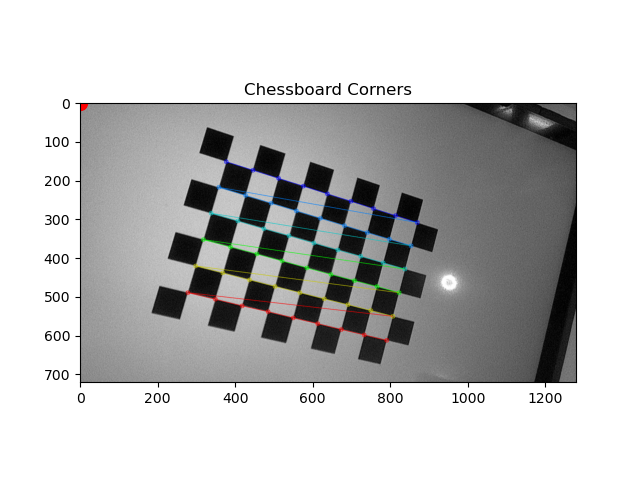

In [6]:
# Visualize the first image with detected corners
# Read left image for visualization
num = 20
image = cv2.imread(valid_left_images[num])
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
J1 = cv2.remap(gray, map1_x, map1_y, interpolation=cv2.INTER_LINEAR)
img_viz = cv2.cvtColor(J1, cv2.COLOR_GRAY2BGR)
# Draw the corners
cv2.drawChessboardCorners(img_viz, (num_interior_corners_x, num_interior_corners_y), image_points[num], True)

plt.figure()
plt.imshow(img_viz)
plt.scatter(0, 0, c='r', marker='o', label='First Object Point', s=100)
plt.title("Chessboard Corners")
plt.show()

In [7]:
# # Vizualize image points
# image = cv2.imread(leftImages[0])
# gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# J1 = cv2.remap(gray, map1_x, map1_y, interpolation=cv2.INTER_LINEAR)
# img_viz = cv2.cvtColor(J1, cv2.COLOR_GRAY2BGR)

# points = image_points[0].squeeze()

# plt.figure()
# plt.imshow(img_viz)
# plt.scatter(points[:, 0], points[:, 1], c='b', marker='o', label='Image Points')
# plt.scatter(points[0, 0], points[0, 1], c='r', marker='o', label='First Image Point', s=100)
# plt.scatter(points[1, 0], points[1, 1], c='g', marker='o', label='Second Image Point', s=100)
# plt.legend()
# plt.xlabel('X (pixels)')
# plt.ylabel('Y (pixels)')
# plt.title("Image Points Visualization")
# plt.show()




In [8]:
# Initialize lists for storing results
R_world2cam = []
t_world2cam = []
T_world2cam = []

R_base2gripper = []
t_base2gripper = []
T_base2gripper = []

R_gripper2base = []
t_gripper2base = []
T_gripper2base = []

R_base2world = []
t_base2world = []
T_base2world = []

R_gripper2cam = []
t_gripper2cam = []
T_gripper2cam = []



# Use rectified camera matrix for left rectified images
K1_rect = P1[:3, :3]        # P1 from cv2.stereoRectify
D1_rect = np.zeros(5)       # or np.zeros(8) if using 8-coeff model

for img_pts, obj_pts in zip(image_points, object_points):
    success, rvec, tvec = cv2.solvePnP(obj_pts, img_pts, K1_rect, D1_rect)
    if not success:
        print("solvePnP failed for a board.")
        continue
    R, _ = cv2.Rodrigues(rvec)
    R_world2cam.append(R)
    t_world2cam.append(tvec)
    T_world2cam.append(to_homogeneous(R, tvec))


Mean reprojection error: 0.15 pixels
RMS reprojection error: 0.17 pixels


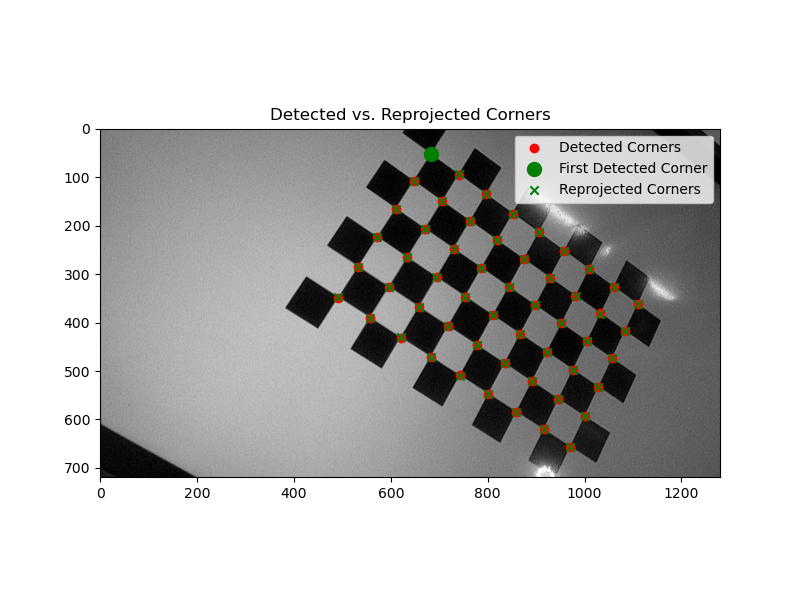

In [9]:
# Vizualize the first image with detected corners and reprojection for validation
imgnum = 2  # Index of the image to visualize

image = cv2.imread(valid_left_images[imgnum])
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
J1 = cv2.remap(gray, map1_x, map1_y, interpolation=cv2.INTER_LINEAR)
img_viz = cv2.cvtColor(J1, cv2.COLOR_GRAY2BGR)

points = image_points[imgnum].squeeze()

# Project the 3D world points to 2D image points using the estimated pose
projected_img_pts, _ = cv2.projectPoints(object_points[imgnum], R_world2cam[imgnum], t_world2cam[imgnum], K1_rect, D1_rect)
projected_img_pts = projected_img_pts.squeeze()  # (N, 2)

# Compute per-point reprojection error
errors = np.linalg.norm(points - projected_img_pts, axis=1)
mean_error = np.mean(errors)
rms_error = np.sqrt(np.mean(errors**2))

print(f"Mean reprojection error: {mean_error:.2f} pixels")
print(f"RMS reprojection error: {rms_error:.2f} pixels")

# (Optional) Visualize detected and projected points overlayed on the image
plt.figure(figsize=(8, 6))
plt.imshow(img_viz, cmap='gray')
plt.scatter(points[:, 0], points[:, 1], c='r', marker='o', label='Detected Corners')
plt.scatter(projected_img_pts[0,0], projected_img_pts[0,1], c='g', marker='o', label='First Detected Corner', s=100)
plt.scatter(projected_img_pts[:, 0], projected_img_pts[:, 1], c='g', marker='x', label='Reprojected Corners')
plt.legend()
plt.title('Detected vs. Reprojected Corners')
plt.show()

In [10]:
# # Plot world points in camera frame
# imgnumidx = 0  # Index of the image to visualize
# R_world2cam_matrix = R_world2cam[imgnumidx]
# t_world2cam_vector = t_world2cam[imgnumidx]
# object_points_in_world = object_points[imgnumidx]

# # Transform object points to camera frame
# object_points_in_camera = (R_world2cam_matrix @ object_points_in_world.T + t_world2cam_vector).T

# fig = plt.figure(figsize=(8, 6))
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(object_points_in_camera[:, 0], object_points_in_camera[:, 1], object_points_in_camera[:, 2], c='b', marker='o', label='Object Points')
# ax.scatter(object_points_in_camera[0, 0], object_points_in_camera[0, 1], object_points_in_camera[0, 2], c='r', marker='o', label='First Object Point', s=100)
# ax.scatter(object_points_in_camera[1, 0], object_points_in_camera[1, 1], object_points_in_camera[1, 2], c='g', marker='o', label='Second Object Point', s=100)
# ax.scatter(0, 0, 0, c='k', marker='x', label='Camera Origin', s=100)  # Camera origin
# ax.set_xlabel('X (mm)')
# ax.set_ylabel('Y (mm)')
# ax.set_zlabel('Z (m)')
# ax.set_title('3D Object Points in Camera Frame')
# ax.legend()
# plt.show()

In [11]:
# # Plot camera pose in world frame
# imgnumidx = 0  # Index of the image to visualize
# R_wc = R_world2cam[imgnumidx]  # 3x3 rotation matrix, world-to-camera
# t_wc = t_world2cam[imgnumidx] # 3x1 translation vector, world-to-camera
# object_points_in_world = object_points[imgnumidx]
# # Camera center in world frame
# C_world = -R_wc.T @ t_wc

# R_cw = R_wc.T  # Invert rotation matrix to get camera orientation in world frame  

# # Plot world points and camera
# fig = plt.figure(figsize=(8, 6))
# ax = fig.add_subplot(111, projection='3d')

# # Plot checkerboard/world points
# ax.scatter(object_points_in_world[:, 0], object_points_in_world[:, 1], object_points_in_world[:, 2], c='b', label='Checkerboard (World)')
# ax.scatter(object_points_in_world[0, 0], object_points_in_world[0, 1], object_points_in_world[0, 2], c='r', s=100, label='First Object Point (World)')
# ax.scatter(object_points_in_world[1, 0], object_points_in_world[1, 1], object_points_in_world[1, 2], c='g', s=100, label='Second Object Point (World)')
# # Plot camera center
# ax.scatter(C_world[0], C_world[1], C_world[2], c='b', marker='x', label='Camera Center (World)', s=100)
# # Plot camera orientation
# camera_axis_length = 50  # Length of the camera axes for visualization
# ax.quiver(C_world[0], C_world[1], C_world[2],
#           camera_axis_length * R_cw[0, 0], camera_axis_length * R_cw[1, 0], camera_axis_length * R_cw[2, 0],
#           color='r', label='Camera X-axis', length=camera_axis_length, normalize=True)
# ax.quiver(C_world[0], C_world[1], C_world[2],
#           camera_axis_length * R_cw[0, 1], camera_axis_length * R_cw[1, 1], camera_axis_length * R_cw[2, 1],
#           color='g', label='Camera Y-axis', length=camera_axis_length, normalize=True)
# ax.quiver(C_world[0], C_world[1], C_world[2],
#           camera_axis_length * R_cw[0, 2], camera_axis_length * R_cw[1, 2], camera_axis_length * R_cw[2, 2],
#           color='b', label='Camera Z-axis', length=camera_axis_length, normalize=True)

# ax.set_xlabel('X (mm)')
# ax.set_ylabel('Y (mm)')
# ax.set_zlabel('Z (mm)')
# ax.set_title('Camera Pose in World Coordinates')
# ax.legend()
# plt.show()

In [12]:
# Process mocap data
mocapdir = os.path.join(basePath, handeyefolder, "mocapimages")
csvFiles = natsort.natsorted(glob.glob(os.path.join(mocapdir, '*.csv')))

# Check if any CSV files were found
if not csvFiles:
    raise RuntimeError(f'No CSV files found in {mocapdir}')

# Filter bad csv files based on bad images
if badImages:
    csvFiles = [f for i, f in enumerate(csvFiles) if i not in badImages]

num_poses = len(csvFiles)


for fname in csvFiles:
    tbl = pd.read_csv(fname, skiprows=3)

    # Read rotation and translation data measured in deg and mm respectively
    rot_x = pd.to_numeric(tbl['StereoEndoscope'][3:], errors='coerce')
    rot_y = pd.to_numeric(tbl['StereoEndoscope.1'][3:], errors='coerce')
    rot_z = pd.to_numeric(tbl['StereoEndoscope.2'][3:], errors='coerce')
    t_x = pd.to_numeric(tbl['StereoEndoscope.3'][3:], errors='coerce')
    t_y = pd.to_numeric(tbl['StereoEndoscope.4'][3:], errors='coerce')
    t_z = pd.to_numeric(tbl['StereoEndoscope.5'][3:], errors='coerce')
    
    # Remove NaN values and compute averages
    avg_rx, avg_ry, avg_rz = np.nanmean(rot_x), np.nanmean(rot_y), np.nanmean(rot_z)
    avg_tx, avg_ty, avg_tz = np.nanmean(t_x), np.nanmean(t_y), np.nanmean(t_z)

    # Convert degrees to radians for euler->matrix conversion (intrinsic)
    rotm = ROT.from_euler('XYZ', [avg_rx, avg_ry, avg_rz], degrees=True).as_matrix()
    tvec = np.array([avg_tx, avg_ty, avg_tz])

    # Save gripper to base rotation and translation matrices
    R_gripper2base.append(rotm)
    t_gripper2base.append(tvec)
    T_gripper2base.append(to_homogeneous(rotm, tvec))
    
    # Save base to gripper rotation and translation matrices by inverting them
    R_base2gripper.append(rotm.T)
    t_base2gripper.append(-rotm.T @ tvec)
    T_base2gripper.append(to_homogeneous(rotm.T, -rotm.T @ tvec))

In [13]:
# Hand-Eye Calibration

# Perform Hand-Eye calibration using the Shah method
R_base2world, t_base2world, R_gripper2cam, t_gripper2cam = cv2.calibrateRobotWorldHandEye(R_world2cam, t_world2cam,  R_base2gripper, t_base2gripper, method=cv2.CALIB_ROBOT_WORLD_HAND_EYE_SHAH)

# Print if the calibration was successful if all output is not None
if R_base2world is not None and t_base2world is not None and R_gripper2cam is not None and t_gripper2cam is not None:
    print("✅ Hand-Eye calibration successful!")
else:
    print("❌ Hand-Eye calibration failed. Check your data and parameters.")

T_base2world = to_homogeneous(R_base2world, t_base2world)
T_gripper2cam = to_homogeneous(R_gripper2cam, t_gripper2cam)

✅ Hand-Eye calibration successful!


In [14]:
# # Hand-Eye calibration using tsai,park,horaud,andreff,danilidis

# # Initialize lists for storing relative motions for X
# Ax_rot = []
# Ax_t = []
# Bx_rot = []
# Bx_t = []
# # Initialize lists for storing relative motions for Z
# Az_rot = []
# Az_t = []
# Bz_rot = []
# Bz_t = []

# for i in range(num_poses):
#     for j in range(i+1, num_poses):
#         # 1. A (relative camera motion, world->cam)
#         A_i = T_world2cam[i]
#         A_j = T_world2cam[j]
#         A_rel = np.linalg.inv(A_j) @ A_i
#         Ax_rot.append(A_rel[:3, :3])
#         Ax_t.append(A_rel[:3, 3])

#         # 2. B (relative marker motion, base->gripper)
#         B_i = T_base2gripper[i] 
#         B_j = T_base2gripper[j]
#         B_rel = np.linalg.inv(B_j) @ B_i
#         Bx_rot.append(B_rel[:3, :3])
#         Bx_t.append(B_rel[:3, 3])
        
# for i in range(num_poses):
#     for j in range(i+1, num_poses):
#         # 1. A_z (relative camera motion, world->cam)
#         A_i = T_world2cam[i]
#         A_j = T_world2cam[j]
#         A_rel = A_j @ np.linalg.inv(A_i)
#         Az_rot.append(A_rel[:3, :3])
#         Az_t.append(A_rel[:3, 3])

#         # 2. B_z (relative marker motion, base->gripper)
#         B_i = T_base2gripper[i] 
#         B_j = T_base2gripper[j]
#         B_rel = B_j @ np.linalg.inv(B_i)
#         Bz_rot.append(B_rel[:3, :3])
#         Bz_t.append(B_rel[:3, 3])

# # Save transformation between optical to world, all methods X base to world
# R_base2world_tsai, t_base2world_tsai = cv2.calibrateHandEye(Ax_rot, Ax_t, Bx_rot, Bx_t, method=cv2.CALIB_HAND_EYE_TSAI)
# R_base2world_park, t_base2world_park = cv2.calibrateHandEye(Ax_rot, Ax_t, Bx_rot, Bx_t, method=cv2.CALIB_HAND_EYE_PARK)
# R_base2world_horaud, t_base2world_horaud = cv2.calibrateHandEye(Ax_rot, Ax_t, Bx_rot, Bx_t, method=cv2.CALIB_HAND_EYE_HORAUD)
# R_base2world_andreff, t_base2world_andreff = cv2.calibrateHandEye(Ax_rot, Ax_t, Bx_rot, Bx_t, method=cv2.CALIB_HAND_EYE_ANDREFF)
# R_base2world_dani, t_base2world_dani = cv2.calibrateHandEye(Ax_rot, Ax_t, Bx_rot, Bx_t, method=cv2.CALIB_HAND_EYE_DANIILIDIS)

# # Save transformation between optical to world, all methods Z gripper to cam
# R_gripper2cam_tsai, t_gripper2cam_tsai = cv2.calibrateHandEye(Az_rot, Az_t, Bz_rot, Bz_t, method=cv2.CALIB_HAND_EYE_TSAI)
# R_gripper2cam_park, t_gripper2cam_park = cv2.calibrateHandEye(Az_rot, Az_t, Bz_rot, Bz_t, method=cv2.CALIB_HAND_EYE_PARK)
# R_gripper2cam_horaud, t_gripper2cam_horaud = cv2.calibrateHandEye(Az_rot, Az_t, Bz_rot, Bz_t, method=cv2.CALIB_HAND_EYE_HORAUD)
# R_gripper2cam_andreff, t_gripper2cam_andreff = cv2.calibrateHandEye(Az_rot, Az_t, Bz_rot, Bz_t, method=cv2.CALIB_HAND_EYE_ANDREFF)
# R_gripper2cam_dani, t_gripper2cam_dani = cv2.calibrateHandEye(Az_rot, Az_t, Bz_rot, Bz_t, method=cv2.CALIB_HAND_EYE_DANIILIDIS)

In [24]:
# Final Hand-Eye Calibration Validation
rms_shah = []
rms_tsai = []
rms_park = []
rms_horaund = []
rms_andreff = []
rms_dani = []

for i in range(len(valid_left_images)):
    # Read, gray, and undistort the left image for validation
    image = cv2.imread(valid_left_images[i])
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    J1 = cv2.remap(gray, map1_x, map1_y, interpolation=cv2.INTER_LINEAR)
    img_viz = cv2.cvtColor(J1, cv2.COLOR_GRAY2BGR)

    # Transform world points to homogeneous coordinates
    world_pts = object_points[i]  
    ones = np.ones((world_pts.shape[0], 1))
    world_pts_h = np.hstack((world_pts, ones))

    # # Build the transformation chain: World -> Base -> Gripper -> Camera
    T_base2gripper_pose = np.linalg.inv(T_gripper2base[i]) 
    
    # Shah
    T_world2base = np.linalg.inv(T_base2world)
    T_world2cam_shah = T_gripper2cam @ T_base2gripper_pose @ T_world2base

    # Transform world points to camera frame
    pts_cam_h = (T_world2cam_shah @ world_pts_h.T).T  # (N, 4)
    pts_cam_shah = pts_cam_h[:, :3]
    
    # Project 3D camera points to left 2D image plane
    img_pts_pred_shah, _ = cv2.projectPoints(pts_cam_shah, np.zeros(3), np.zeros(3), K1_rect, D1_rect)
    img_pts_pred_shah = img_pts_pred_shah.squeeze()  # (N, 2)

    detected = image_points[i].squeeze()

    # Compute reprojection error
    errors_shah = np.linalg.norm(detected - img_pts_pred_shah, axis=1)
    rms_shah.append(errors_shah)

# Print root mean square error
print("RMS error (Pixels):", np.sqrt(np.mean(np.array(rms_shah)**2)))

# Validate the calibration by checking the loop chain (world to base to gripper to cam to world)
roterrors = []
terrors = []

for i in range(len(valid_left_images)):

    # Build the chain world to base to gripper to camera to world
    loop_chain = np.linalg.inv(T_world2cam[i]) @ T_gripper2cam @ T_base2gripper[i] @ T_world2base

    # Compute translation and rotation errors
    R_error = np.linalg.norm(loop_chain[:3, :3] - np.eye(3), ord='fro')  
    t_error = np.linalg.norm(loop_chain[:3, 3])  
    roterrors.append(R_error)
    terrors.append(t_error)

# print root mean square rotation and translation error
print("RMS loop chain rotation error:", np.sqrt(np.mean(np.array(roterrors)**2)))
print("RMS loop chain translation error:", np.sqrt(np.mean(np.array(terrors)**2)))


RMS error (Pixels): 8.945881232044197
RMS loop chain rotation error: 0.00581901548742797
RMS loop chain translation error: 1.3156312999593565


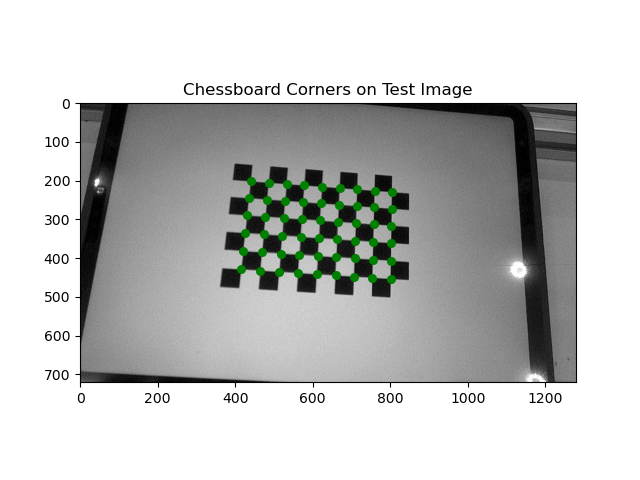

In [17]:
# Testing
valtest = 0

# Get sorted list of left camera PNG files
leftFoldertest = os.path.join(basePath, testfolder, method, resolution, 'left')
leftImagestest = natsort.natsorted(glob.glob(os.path.join(leftFoldertest, '*.png')))

# Read, gray, and rectify the test image
imagetest = cv2.imread(leftImagestest[valtest])
graytest = cv2.cvtColor(imagetest, cv2.COLOR_BGR2GRAY)
J1test = cv2.remap(graytest, map1_x, map1_y, interpolation=cv2.INTER_LINEAR)
# Convert to BGR for visualization
img_viztest = cv2.cvtColor(J1test, cv2.COLOR_GRAY2BGR)

# Detect checkerboard corners on left image
foundtest, cornerstest = cv2.findChessboardCorners(J1test, (num_interior_corners_x, num_interior_corners_y))

# Check if corners were found
if not foundtest or cornerstest is None or np.isnan(cornerstest).any():
    raise RuntimeError("❌ Checkerboard not found in test image.")

# Refine corner locations
corners2test = cv2.cornerSubPix(J1test, cornerstest, (11,11), (-1,-1),
                            criteria=(cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001))

image_points_test = corners2test.squeeze()

# Draw the corners
# cv2.drawChessboardCorners(img_viztest, (num_interior_corners_x, num_interior_corners_y), corners2test, True)

plt.figure()
plt.imshow(img_viztest)
plt.scatter(image_points_test[:, 0], image_points_test[:, 1], c='g', marker='o', s=30)
plt.title("Chessboard Corners on Test Image")
plt.show()


success, rvectest, tvectest = cv2.solvePnP(obj_pts, image_points_test, K1_rect, D1_rect)

if not success:
    print("solvePnP failed for a board.")

R, _ = cv2.Rodrigues(rvectest)
T_world2camtest = to_homogeneous(R, tvectest)



In [18]:
# Define transformation matrices for test data
T_tiptobasetest = [] # transformation from tip to optical space
T_grippertobasetest = [] # transformation from marker to optical space
predicted_tip = []

# Read mocap csv files
mocapdirtest = os.path.join(basePath, testfolder, "mocapimages")
csvFiletest = natsort.natsorted(glob.glob(os.path.join(mocapdirtest, '*.csv')))

# Check if any CSV files were found
if not csvFiletest:
    raise RuntimeError(f'No CSV files found in {mocapdirtest}')

for fname in csvFiletest:
    # Read the CSV file
    tbl = pd.read_csv(fname, skiprows=3)

    # Marker pose (scope)
    rxm = pd.to_numeric(tbl['StereoEndoscope'][3:], errors='coerce')
    rym = pd.to_numeric(tbl['StereoEndoscope.1'][3:], errors='coerce')
    rzm = pd.to_numeric(tbl['StereoEndoscope.2'][3:], errors='coerce')
    txm = pd.to_numeric(tbl['StereoEndoscope.3'][3:], errors='coerce')
    tym = pd.to_numeric(tbl['StereoEndoscope.4'][3:], errors='coerce')
    tzm = pd.to_numeric(tbl['StereoEndoscope.5'][3:], errors='coerce')
    # Remove NaN values and compute averages
    avg_rxm, avg_rym, avg_rzm = np.nanmean(rxm), np.nanmean(rym), np.nanmean(rzm)
    avg_txm, avg_tym, avg_tzm = np.nanmean(txm), np.nanmean(tym), np.nanmean(tzm)
    # Convert degrees to radians for euler->matrix conversion
    R_marker = ROT.from_euler('XYZ', [avg_rxm, avg_rym, avg_rzm], degrees=True).as_matrix()
    t_marker = np.array([avg_txm, avg_tym, avg_tzm])
    # Build homogeneous transformation matrix
    T_grippertobasetest.append(to_homogeneous(R_marker, t_marker))

    # Tip pose (forceps)
    rx = pd.to_numeric(tbl['Forceps'][3:], errors='coerce')
    ry = pd.to_numeric(tbl['Forceps.1'][3:], errors='coerce')
    rz = pd.to_numeric(tbl['Forceps.2'][3:], errors='coerce')
    tx = pd.to_numeric(tbl['Forceps.3'][3:], errors='coerce')
    ty = pd.to_numeric(tbl['Forceps.4'][3:], errors='coerce')
    tz = pd.to_numeric(tbl['Forceps.5'][3:], errors='coerce')
    # Remove NaN values and compute averages
    avg_rx, avg_ry, avg_rz = np.nanmean(rx), np.nanmean(ry), np.nanmean(rz)
    avg_tx, avg_ty, avg_tz = np.nanmean(tx), np.nanmean(ty), np.nanmean(tz)
    # Convert degrees to radians for euler->matrix conversion
    R_tip = ROT.from_euler('XYZ', [avg_rx, avg_ry, avg_rz], degrees=True).as_matrix()
    t_tip = np.array([avg_tx, avg_ty, avg_tz])
    # Build homogeneous transformation matrix
    T_tiptobasetest.append(to_homogeneous(R_tip, t_tip))

In [20]:
# Get predicted tip positions in world coordinates
for f in range(len(T_tiptobasetest)):

    tip_in_world = np.linalg.inv(T_world2camtest) @ T_gripper2cam @ np.linalg.inv(T_grippertobasetest[f]) @ T_tiptobasetest[f]

    predicted_tip.append(tip_in_world[:3])  # Store only x, y, z

predicted_tip = np.vstack(predicted_tip)  # shape: (N, 3)


🧪 Testing Hand-Eye Calibration with Forceps Tip Positioning
📊 Available data:
   Test images: 1
   Mocap tip poses: 5
   Mocap gripper poses: 5
✅ Successfully processed test image and established world coordinate system

🎯 Transforming 5 tip positions to world coordinates...
Mocap pose 1: Tip world position = [2.14, 4.83, 16.26] mm
Mocap pose 2: Tip world position = [79.61, 5.03, 19.21] mm
Mocap pose 3: Tip world position = [-6.70, 56.68, 16.90] mm
Mocap pose 4: Tip world position = [73.34, 60.38, 20.65] mm
Mocap pose 5: Tip world position = [33.68, 34.59, 19.84] mm

📈 Successfully computed 5 tip positions in world coordinates

📊 Tip Position Accuracy Analysis:
Number of tip positions: 5
Tip centroid: [36.41, 32.30, 18.57] mm
Mean distance from centroid: 38.969 mm
Max distance from centroid: 51.090 mm
Standard deviation: 17.766 mm
Mean pairwise distance: 64.866 mm
Max pairwise distance: 100.615 mm

🎯 Hand-Eye Calibration Accuracy Assessment:
Overall accuracy: Poor (> 10 mm)
Tip cluster

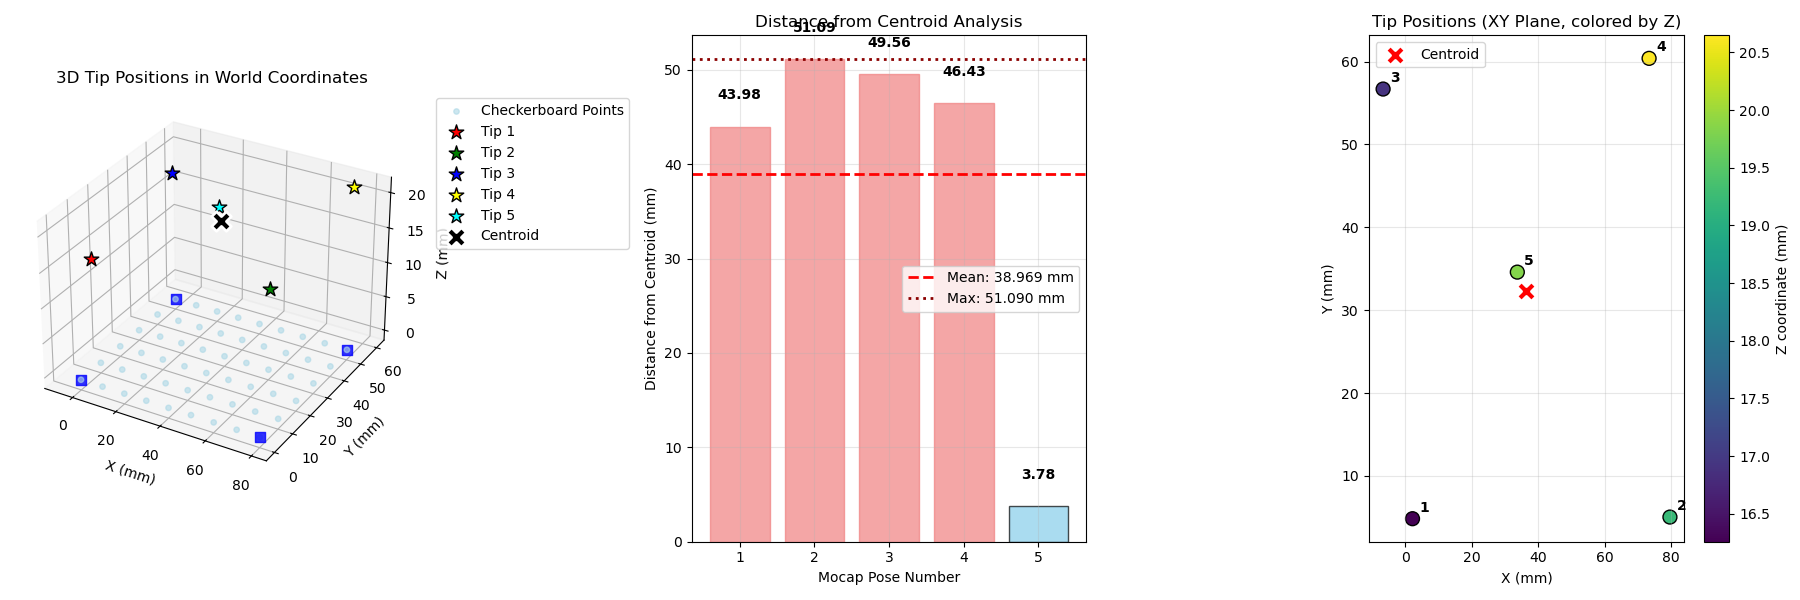


📋 Detailed Results Table:
Pose  X (mm)   Y (mm)   Z (mm)   Dist from Centroid Notes          
--------------------------------------------------------------------------------
1     2.14     4.83     16.26    43.983             Normal         
2     79.61    5.03     19.21    51.090             Normal         
3     -6.70    56.68    16.90    49.560             Normal         
4     73.34    60.38    20.65    46.434             Normal         
5     33.68    34.59    19.84    3.780              Normal         

✅ Hand-eye calibration testing completed!
📊 Results: 5 tips positioned with 51.090 mm max deviation
🎯 Calibration quality: Poor (> 10 mm)


In [23]:
# Hand-Eye Calibration Testing: Transform Forceps Tips to World Coordinates
# Modified approach for multiple mocap poses with single test image

print("🧪 Testing Hand-Eye Calibration with Forceps Tip Positioning")
print("="*70)

# Check available data
print(f"📊 Available data:")
print(f"   Test images: {len(leftImagestest)}")
print(f"   Mocap tip poses: {len(T_tiptobasetest)}")
print(f"   Mocap gripper poses: {len(T_grippertobasetest)}")

# Process the single test image to get the reference world coordinate system
test_idx = 0  # Use the first (and only) test image
imagetest = cv2.imread(leftImagestest[test_idx])
graytest = cv2.cvtColor(imagetest, cv2.COLOR_BGR2GRAY)
J1test = cv2.remap(graytest, map1_x, map1_y, interpolation=cv2.INTER_LINEAR)

# Detect checkerboard corners
foundtest, cornerstest = cv2.findChessboardCorners(J1test, (num_interior_corners_x, num_interior_corners_y))

if not foundtest or cornerstest is None or np.isnan(cornerstest).any():
    raise RuntimeError("❌ Checkerboard not found in test image. Cannot proceed.")

# Refine corner locations
corners2test = cv2.cornerSubPix(J1test, cornerstest, (11,11), (-1,-1),
                            criteria=(cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001))

image_points_test = corners2test.squeeze()

# Solve PnP to get world-to-camera transformation for the test image
success, rvectest, tvectest = cv2.solvePnP(object_points_3D, image_points_test, K1_rect, D1_rect)

if not success:
    raise RuntimeError("❌ solvePnP failed for test image. Cannot proceed.")

R_test, _ = cv2.Rodrigues(rvectest)
T_world2cam_test = to_homogeneous(R_test, tvectest)
T_cam2world_test = np.linalg.inv(T_world2cam_test)

print(f"✅ Successfully processed test image and established world coordinate system")

# Transform tip positions to world coordinates for all mocap poses
print(f"\n🎯 Transforming {len(T_tiptobasetest)} tip positions to world coordinates...")

predicted_tips_world = []
transformation_details = []

for mocap_idx in range(len(T_tiptobasetest)):
    
    # Complete transformation chain: Tip → Base → Gripper → Camera → World
    # T_tip2world = T_cam2world @ T_gripper2cam @ T_base2gripper @ T_tip2base
    
    T_base2gripper_test = np.linalg.inv(T_grippertobasetest[mocap_idx])
    
    # Build the complete transformation chain
    T_tip2world = T_cam2world_test @ T_gripper2cam @ T_base2gripper_test @ T_tiptobasetest[mocap_idx]
    
    # Extract tip position in world coordinates
    tip_position_world = T_tip2world[:3, 3]
    predicted_tips_world.append(tip_position_world)
    
    # Store details for analysis
    transformation_details.append({
        'mocap_pose': mocap_idx + 1,
        'tip_world': tip_position_world,
        'gripper_pose': T_grippertobasetest[mocap_idx][:3, 3],
        'tip_pose': T_tiptobasetest[mocap_idx][:3, 3]
    })
    
    print(f"Mocap pose {mocap_idx + 1}: Tip world position = [{tip_position_world[0]:.2f}, {tip_position_world[1]:.2f}, {tip_position_world[2]:.2f}] mm")

# Convert to numpy array for analysis
predicted_tips_world_array = np.array(predicted_tips_world)

print(f"\n📈 Successfully computed {len(predicted_tips_world)} tip positions in world coordinates")

# Analyze the tip positioning accuracy
if len(predicted_tips_world) > 1:
    
    # Calculate statistics about tip positions
    tip_centroid = np.mean(predicted_tips_world_array, axis=0)
    distances_from_centroid = np.linalg.norm(predicted_tips_world_array - tip_centroid, axis=1)
    max_distance = np.max(distances_from_centroid)
    mean_distance = np.mean(distances_from_centroid)
    std_distance = np.std(distances_from_centroid)
    
    # Calculate pairwise distances between all tip positions
    pairwise_distances = []
    for i in range(len(predicted_tips_world)):
        for j in range(i+1, len(predicted_tips_world)):
            dist = np.linalg.norm(predicted_tips_world_array[i] - predicted_tips_world_array[j])
            pairwise_distances.append(dist)
    
    max_pairwise_distance = np.max(pairwise_distances) if pairwise_distances else 0
    mean_pairwise_distance = np.mean(pairwise_distances) if pairwise_distances else 0
    
    print(f"\n📊 Tip Position Accuracy Analysis:")
    print("="*50)
    print(f"Number of tip positions: {len(predicted_tips_world)}")
    print(f"Tip centroid: [{tip_centroid[0]:.2f}, {tip_centroid[1]:.2f}, {tip_centroid[2]:.2f}] mm")
    print(f"Mean distance from centroid: {mean_distance:.3f} mm")
    print(f"Max distance from centroid: {max_distance:.3f} mm")
    print(f"Standard deviation: {std_distance:.3f} mm")
    print(f"Mean pairwise distance: {mean_pairwise_distance:.3f} mm")
    print(f"Max pairwise distance: {max_pairwise_distance:.3f} mm")
    
    # Accuracy assessment
    print(f"\n🎯 Hand-Eye Calibration Accuracy Assessment:")
    if max_distance < 1.0:
        accuracy = "Excellent (< 1 mm)"
    elif max_distance < 2.0:
        accuracy = "Very Good (< 2 mm)"
    elif max_distance < 5.0:
        accuracy = "Good (< 5 mm)"
    elif max_distance < 10.0:
        accuracy = "Acceptable (< 10 mm)"
    else:
        accuracy = "Poor (> 10 mm)"
    
    print(f"Overall accuracy: {accuracy}")
    print(f"Tip clustering quality: {std_distance:.3f} mm standard deviation")
    
    # Additional analysis: Check if the tip should be at the same location
    print(f"\n🔍 Interpretation:")
    print(f"   - If the forceps tip was held stationary during data collection:")
    print(f"     The {max_distance:.3f} mm max deviation indicates the hand-eye calibration accuracy")
    print(f"   - If the tip was moved between poses:")
    print(f"     The spread shows the range of tip positions in world space")

else:
    print(f"\n❌ Only {len(predicted_tips_world)} tip position available - cannot assess accuracy")

# Enhanced visualization
fig = plt.figure(figsize=(18, 6))

# Plot 1: 3D visualization of tip positions and checkerboard
ax1 = fig.add_subplot(131, projection='3d')

# Plot checkerboard
ax1.scatter(object_points_3D[:, 0], object_points_3D[:, 1], object_points_3D[:, 2], 
           c='lightblue', marker='o', s=15, alpha=0.6, label='Checkerboard Points')

# Highlight corners for reference
corners_to_highlight = [0, 8, 45, 53]  # Corners of the checkerboard
for i, corner_idx in enumerate(corners_to_highlight):
    ax1.scatter(object_points_3D[corner_idx, 0], object_points_3D[corner_idx, 1], object_points_3D[corner_idx, 2], 
               c='blue', marker='s', s=50, alpha=0.8)

# Plot tip positions
colors = ['red', 'green', 'blue', 'yellow', 'cyan', 'magenta', 'orange', 'purple']
for i, tip in enumerate(predicted_tips_world_array):
    color = colors[i % len(colors)]
    ax1.scatter(tip[0], tip[1], tip[2], c=color, marker='*', s=120, 
               label=f'Tip {i+1}', edgecolors='black', linewidth=1)

# Plot centroid if multiple tips
if len(predicted_tips_world) > 1:
    ax1.scatter(tip_centroid[0], tip_centroid[1], tip_centroid[2], 
               c='black', marker='X', s=200, label='Centroid', edgecolors='white', linewidth=2)

ax1.set_xlabel('X (mm)')
ax1.set_ylabel('Y (mm)')
ax1.set_zlabel('Z (mm)')
ax1.set_title('3D Tip Positions in World Coordinates')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot 2: Distance analysis
if len(predicted_tips_world) > 1:
    ax2 = fig.add_subplot(132)
    bars = ax2.bar(range(1, len(predicted_tips_world)+1), distances_from_centroid, 
                   color='skyblue', edgecolor='black', alpha=0.7)
    
    # Color bars based on distance
    for i, bar in enumerate(bars):
        if distances_from_centroid[i] > mean_distance:
            bar.set_color('lightcoral')
    
    ax2.axhline(mean_distance, color='red', linestyle='--', linewidth=2, 
               label=f'Mean: {mean_distance:.3f} mm')
    ax2.axhline(max_distance, color='darkred', linestyle=':', linewidth=2, 
               label=f'Max: {max_distance:.3f} mm')
    ax2.set_xlabel('Mocap Pose Number')
    ax2.set_ylabel('Distance from Centroid (mm)')
    ax2.set_title('Distance from Centroid Analysis')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for i, v in enumerate(distances_from_centroid):
        ax2.text(i+1, v + 0.05*max_distance, f'{v:.2f}', ha='center', va='bottom', fontweight='bold')

# Plot 3: Coordinate analysis
ax3 = fig.add_subplot(133)
x_coords = predicted_tips_world_array[:, 0]
y_coords = predicted_tips_world_array[:, 1]
z_coords = predicted_tips_world_array[:, 2]

ax3.scatter(x_coords, y_coords, c=z_coords, cmap='viridis', s=100, 
           edgecolors='black', linewidth=1)

# Add pose labels
for i, (x, y) in enumerate(zip(x_coords, y_coords)):
    ax3.annotate(f'{i+1}', (x, y), xytext=(5, 5), textcoords='offset points', 
                fontweight='bold', fontsize=10)

# Plot centroid
if len(predicted_tips_world) > 1:
    ax3.scatter(tip_centroid[0], tip_centroid[1], c='red', marker='X', s=200, 
               edgecolors='white', linewidth=2, label='Centroid')

ax3.set_xlabel('X (mm)')
ax3.set_ylabel('Y (mm)')
ax3.set_title('Tip Positions (XY Plane, colored by Z)')
ax3.grid(True, alpha=0.3)
ax3.legend()

# Add colorbar for Z values
if len(predicted_tips_world) > 1:
    cbar = plt.colorbar(ax3.collections[0], ax=ax3)
    cbar.set_label('Z coordinate (mm)')

plt.tight_layout()
plt.show()

# Print detailed results table
print(f"\n📋 Detailed Results Table:")
print("="*80)
print(f"{'Pose':<5} {'X (mm)':<8} {'Y (mm)':<8} {'Z (mm)':<8} {'Dist from Centroid':<18} {'Notes':<15}")
print("-"*80)

for i, detail in enumerate(transformation_details):
    tip = detail['tip_world']
    dist = distances_from_centroid[i] if len(predicted_tips_world) > 1 else 0
    note = "Outlier" if len(predicted_tips_world) > 1 and dist > mean_distance + std_distance else "Normal"
    print(f"{detail['mocap_pose']:<5} {tip[0]:<8.2f} {tip[1]:<8.2f} {tip[2]:<8.2f} {dist:<18.3f} {note:<15}")

print(f"\n✅ Hand-eye calibration testing completed!")
if len(predicted_tips_world) > 1:
    print(f"📊 Results: {len(predicted_tips_world)} tips positioned with {max_distance:.3f} mm max deviation")
    print(f"🎯 Calibration quality: {accuracy}")
else:
    print(f"⚠️  Only 1 tip position - need multiple poses for accuracy assessment")

In [ ]:
# Convert Shah Method RMS Errors from Pixels to Millimeters

print(f"Current checker_width: {checker_width} mm")
print(f"Number of poses: {len(rms_shah)}")
print(f"RMS errors in pixels: {rms_shah}")

# Method: Use the known checkerboard square size to convert pixels to mm
# We'll calculate the pixel-to-mm ratio from the checkerboard geometry

# Pick a representative pose to calculate the conversion factor
validx = 0  # Use first pose for conversion calculation

# Read and process the validation image
image = cv2.imread(valid_left_images[validx])
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
J1 = cv2.remap(gray, map1_x, map1_y, interpolation=cv2.INTER_LINEAR)

# Get detected corners for this pose
detected = image_points[validx].squeeze()

# Calculate the average distance between adjacent corners in pixels
pixel_distances = []
for i in range(num_interior_corners_y):
    for j in range(num_interior_corners_x - 1):
        idx1 = i * num_interior_corners_x + j
        idx2 = i * num_interior_corners_x + (j + 1)
        if idx1 < len(detected) and idx2 < len(detected):
            pixel_dist = np.linalg.norm(detected[idx2] - detected[idx1])
            pixel_distances.append(pixel_dist)

# Add vertical distances too for better accuracy
for j in range(num_interior_corners_x):
    for i in range(num_interior_corners_y - 1):
        idx1 = i * num_interior_corners_x + j
        idx2 = (i + 1) * num_interior_corners_x + j
        if idx1 < len(detected) and idx2 < len(detected):
            pixel_dist = np.linalg.norm(detected[idx2] - detected[idx1])
            pixel_distances.append(pixel_dist)

# Average pixel distance between adjacent corners
avg_pixel_distance = np.mean(pixel_distances)

# Real-world distance between adjacent corners (checkerboard square size)
real_world_distance_mm = checker_width  # Already in mm

# Calculate conversion factor: mm per pixel
mm_per_pixel = real_world_distance_mm / avg_pixel_distance

print(f"\nConversion Analysis:")
print(f"Average pixel distance between corners: {avg_pixel_distance:.2f} pixels")
print(f"Real checkerboard square size: {real_world_distance_mm:.3f} mm")
print(f"Conversion factor: {mm_per_pixel:.6f} mm/pixel")

# Convert all RMS errors from pixels to mm
rms_shah_mm = [error_px * mm_per_pixel for error_px in rms_shah]

# Calculate statistics
avg_rms_shah_pixels = np.mean(rms_shah)
avg_rms_shah_mm = np.mean(rms_shah_mm)
std_rms_shah_mm = np.std(rms_shah_mm)

print(f"\n📊 Shah Method RMS Error Results:")
print("="*50)
print(f"Average RMS Error (pixels): {avg_rms_shah_pixels:.3f} px")
print(f"Average RMS Error (mm):     {avg_rms_shah_mm:.3f} mm")
print(f"Standard deviation (mm):    {std_rms_shah_mm:.3f} mm")
print(f"Min RMS Error (mm):         {np.min(rms_shah_mm):.3f} mm")
print(f"Max RMS Error (mm):         {np.max(rms_shah_mm):.3f} mm")

# Quality assessment
print(f"\n✅ Calibration Quality Assessment:")
if avg_rms_shah_mm < 0.5:
    quality = "Excellent"
elif avg_rms_shah_mm < 1.0:
    quality = "Very Good"
elif avg_rms_shah_mm < 2.0:
    quality = "Good"
elif avg_rms_shah_mm < 5.0:
    quality = "Acceptable"
else:
    quality = "Poor"

print(f"   Sub-pixel accuracy: {avg_rms_shah_pixels < 1.0}")
print(f"   Sub-millimeter accuracy: {avg_rms_shah_mm < 1.0}")
print(f"   Overall quality: {quality}")

# Create a simple visualization
plt.figure(figsize=(12, 5))

# Plot 1: RMS errors per pose in pixels
plt.subplot(1, 2, 1)
poses = range(1, len(rms_shah) + 1)
plt.plot(poses, rms_shah, 'o-', color='blue', linewidth=2, markersize=6)
plt.axhline(avg_rms_shah_pixels, color='red', linestyle='--', 
            label=f'Average: {avg_rms_shah_pixels:.2f} px')
plt.xlabel('Pose Number')
plt.ylabel('RMS Error (pixels)')
plt.title('Shah Method: RMS Error per Pose (Pixels)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: RMS errors per pose in mm
plt.subplot(1, 2, 2)
plt.plot(poses, rms_shah_mm, 'o-', color='green', linewidth=2, markersize=6)
plt.axhline(avg_rms_shah_mm, color='red', linestyle='--', 
            label=f'Average: {avg_rms_shah_mm:.3f} mm')
plt.xlabel('Pose Number')
plt.ylabel('RMS Error (mm)')
plt.title('Shah Method: RMS Error per Pose (Millimeters)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()